In [6]:
from dataclasses import dataclass
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import json
from matplotlib import patheffects
from scripts.utils import dref_dataframe, dump_dref
import matplotlib
from scipy import integrate
from statistics import stdev

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['savefig.facecolor'] = (0.0, 0.0, 0.0, 0.0)

sns.set_style("whitegrid")
sns.set_context("poster", font_scale=0.75)
sns.set_palette("colorblind6")


@dataclass
class BTimes:
    build: list[float]
    delay: list[float]
    clean: float | None
    drop: float
    cpu: dict[str, float]


def parse_frag(file: Path) -> pd.DataFrame:
    raw = file.read_text()
    data = ""
    for line in raw.splitlines():
        data += line + ((len(line) + 31) // 32 * 32 - len(line)) * "0"
    huge_pages = len(data)
    out = np.zeros(huge_pages)
    for i, char in enumerate(data):
        level = int(char)
        assert(0 <= level <= 9)
        out[i] = float(level)
    return pd.DataFrame(out)


def load_mode(max_mem: int, mode: str, path: Path, i=0) -> tuple[pd.DataFrame, BTimes]:
    data = pd.read_csv(path / f"out_{i}.csv")
    data["mode"] = mode
    if "time" not in data.columns:
        data["time"] = data.index
    if "total" not in data.columns:
        data["total"] = max_mem
    data["time"] /= 60.0
    data["used"] = data["total"] - data["small"] * 2**12
    data["huge"] = data["total"] - data["huge"] * 2**(12+9)
    data["physical"] = data["rss"]

    data = data.melt(
        id_vars=["mode", "time"],
        var_name="measurement",
        value_name="bytes",
        value_vars=["physical", "used", "huge", "cached"])

    raw: dict = json.load((path / f"times_{i}.json").open())
    times = BTimes(
        x if isinstance(x := raw["build"], list) else [x],
        y if isinstance(y := raw["delay"], list) else [y],
        raw.get("clean") / 60,
        raw["drop"] if "drop" in raw else raw["shrink"],
        raw["cpu"]
    )
    times.build = [t/60 for t in times.build]
    times.delay = [t/60 for t in times.delay]
    return data, times


def load_data(max_mem: int, modes: dict[str, Path]) -> tuple[pd.DataFrame, list[BTimes]]:
    datas: list[pd.DataFrame] = []
    times: list[BTimes] = []
    for mode, path in modes.items():
        data, time = load_mode(max_mem, mode, path)
        datas.append(data)
        times.append(time)
    data = pd.concat(datas, ignore_index=True)
    return data, times


def y_at(data: pd.DataFrame, x: float):
    return data[data["measurement"] == "physical"][(data["time"] - x).abs() < 2/60]["bytes"].max()


def calc_gib_min(data: pd.DataFrame, measurement: str, start: float, end: float) -> float:
    build_d = data[(start <= data["time"])
        & (data["time"] <= end)
        & (data["measurement"] == measurement)]
    return integrate.trapezoid(build_d["bytes"], x=build_d["time"]) / 1024**3


def relplot(
    max_mem: int,
    data: pd.DataFrame,
    times: list[BTimes],
    aspect=1.0,
    height=5,
    col_wrap=10,
    area=False,
    hide: list[int] = [],
    measurement: str = "physical",
    max_baseline=False,
) -> tuple[sns.FacetGrid, dict[str, float]]:
    data = data[(data["measurement"] == measurement) | (data["measurement"] == "used")]

    if max_baseline:
        data.loc[(data["measurement"] == measurement) & (data["mode"] == "baseline"), "bytes"] = max_mem

    col_wrap = min(col_wrap, len(data["mode"].unique()))
    hue_order = [measurement, "used"]
    p = sns.relplot(data=data, kind="line", x="time", y="bytes", col="mode", col_wrap=col_wrap,
                    hue="measurement", hue_order=hue_order, height=height, aspect=aspect, legend=False)

    if len(times) > 1:
        p.set_titles("{col_name}")
    else:
        p.set_titles("")

    modes = data["mode"].unique()
    extra_keys = {}

    for i, time in enumerate(times):
        axis = p.facet_axis(0, i)
        celld = data[data["mode"] == modes[i]]

        tstart = 0
        j = 0
        prefix = ""
        for tbuild, tdelay in zip(time.build, time.delay):
            gib_m = calc_gib_min(celld, measurement, tstart, tbuild)
            used_gib_m = calc_gib_min(celld, "used", tstart, tbuild)
            print(f"{modes[i]}: {gib_m:.2f} GiB*m ({used_gib_m:.2f}), {tbuild - tstart:.2f} min")
            extra_keys[f"{modes[i]}/{j}/run/gib_m"] = gib_m
            extra_keys[f"{modes[i]}/{j}/run/gib_m/used"] = used_gib_m
            extra_keys[f"{modes[i]}/{j}/run/time"] = tbuild - tstart

            tstart = tdelay
            j += 1

        gib_m = calc_gib_min(celld, measurement, 0, time.drop)
        used_gib_m = calc_gib_min(celld, "used", 0, time.drop)
        prefix += f"{gib_m:.2f} GiB*m ({used_gib_m:.2f})"
        extra_keys[f"{modes[i]}/gib_m"] = gib_m
        extra_keys[f"{modes[i]}/gib_m/used"] = used_gib_m

        if area:
            axis.fill_between(
                x=axis.get_lines()[0].get_xdata(),
                y1=axis.get_lines()[0].get_ydata(),
                y2=axis.get_lines()[1].get_ydata(),
                color=sns.crayon_palette(["Yellow"])[0])

        if i in hide:
            axis.clear()
            axis.set_axis_off()

        print(f"{modes[i]}: {prefix}")

    if measurement == "physical":
        p.set(ylabel="Memory consumption [GiB]")
    else:
        p.set(ylabel="Fragmented pages [GiB]")
    p.set(xlabel="Time [min]")
    p.set(ylim=(0, max_mem * 1.1))
    p.set(yticks=[x for x in range(0, max_mem + 1, 2*1024**3)],
        yticklabels=[str(x // 1024**3) for x in range(0, max_mem + 1, 2*1024**3)])
    p.set(facecolor="white")
    # p.set(xlim=(0, max(map(lambda t: max(t.build), times))))

    return p, extra_keys


def visualize(
    max_mem: int,
    modes: dict[str, Path],
    save_as: str | None = None,
    aspect=1.0,
    height=5,
    col_wrap=10,
    area=False,
    hide=[],
    dref=False,
    measurement: str = "physical",
    max_baseline=False,
) -> sns.FacetGrid:
    data, times = load_data(max_mem, modes)
    p, extra_keys = relplot(
        max_mem, data, times, aspect=aspect, height=height, col_wrap=col_wrap,
        area=area, hide=hide, measurement=measurement, max_baseline=max_baseline)
    if save_as:
        p.savefig(Path("compiling/out") / f"{save_as}.svg")
        if dref:
            dref_dataframe(save_as, Path("compiling/out"), ["mode", "measurement", "time"], data)
            with (Path("compiling/out") / f"{save_as}_extra.dref").open("w+") as f:
                dump_dref(f, save_as, extra_keys)
    return p



def parse_inflate(path: Path, iter: int = 1) -> pd.DataFrame:
    meta = json.load((path / f"meta.json").open())
    data = pd.read_csv(path / "out.csv")
    data["iter"] = data.index
    data["shrink"] = (data["shrink"] / 1e9) / meta["args"]["mem"]
    data["grow"] = (data["grow"] / 1e9) / meta["args"]["mem"]
    if "touch" in data.columns:
        data["touch"] = (data["touch"] / 1e9) / (meta["args"]["mem"] - 1)
    if "touch" in data.columns:
        data["touch2"] = (data["touch2"] / 1e9) / (meta["args"]["mem"] - 1)

    match path.stem:
        case n if n.endswith("base-manual"): mode = "virtio-balloon"
        case n if n.endswith("huge-manual"): mode = "virtio-balloon-huge"
        case n if n.endswith("virtio-mem-movable"): mode = "virtio-mem"
        case n if n.endswith("virtio-mem-movable-vfio"): mode = "virtio-mem+VFIO"
        case n if n.endswith("llfree-manual"): mode = "HyperAlloc"
        case n if n.endswith("llfree-manual-vfio"): mode = "HyperAlloc+VFIO"
        case m: mode = m
    data["mode"] = mode
    return pd.DataFrame(data)


baseline: 659.38 GiB*m (283.04), 41.21 min
baseline: 819.84 GiB*m (308.48)


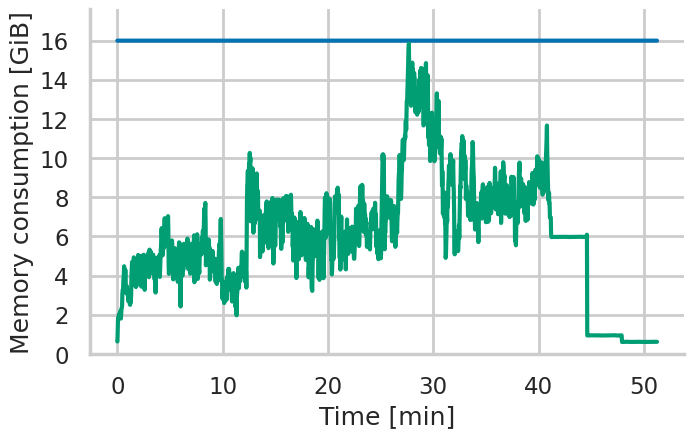

In [4]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "baseline": Path("compiling/latest/clang-base-manual"),
    # "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    # "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "talk-clang-base", height=5, aspect=1.5, max_baseline=True)


baseline: 659.38 GiB*m (283.04), 41.21 min
baseline: 819.84 GiB*m (308.48)


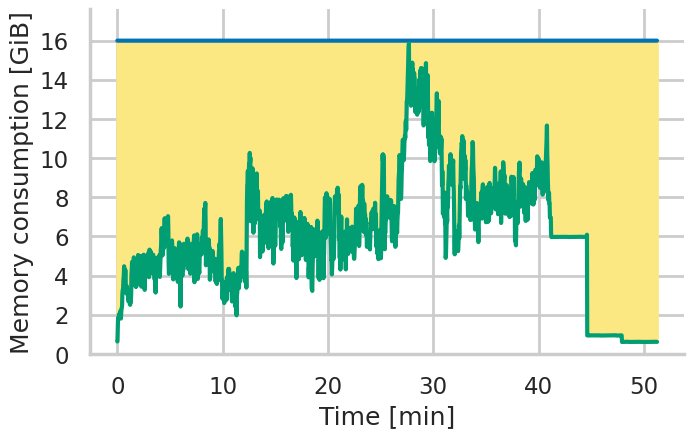

In [5]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "baseline": Path("compiling/latest/clang-base-manual"),
    # "virtio-balloon": Path("compiling/latest-clang-base-auto"),
    # "HyperAlloc": Path("compiling/latest-clang-llfree-auto"),
}, "talk-clang-base-1", height=5, aspect=1.5, area=True, max_baseline=True)


baseline: 484.24 GiB*m (283.04), 41.21 min
baseline: 644.86 GiB*m (308.48)
virtio-balloon(-huge): 430.61 GiB*m (279.51), 41.28 min
virtio-balloon(-huge): 538.36 GiB*m (304.00)
HyperAlloc: 357.68 GiB*m (282.25), 40.79 min
HyperAlloc: 422.96 GiB*m (308.51)


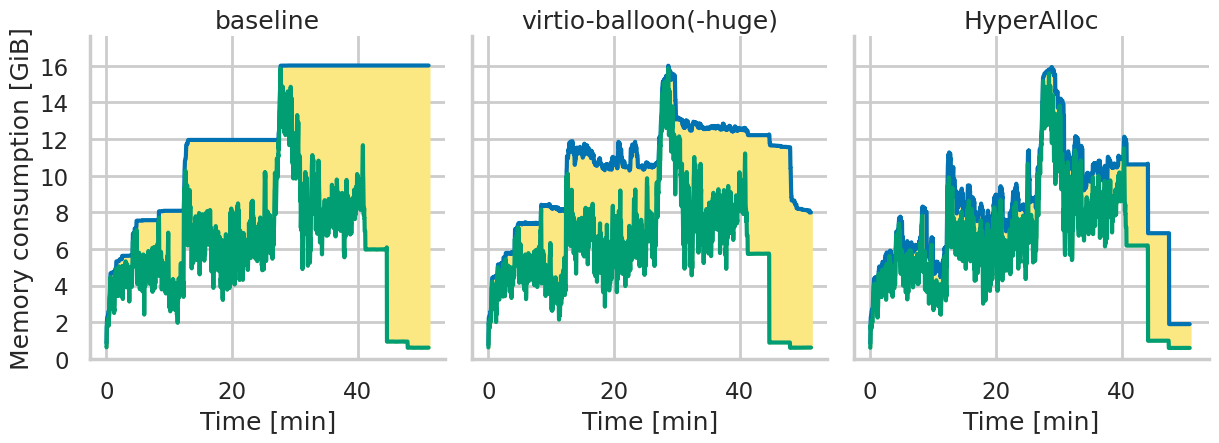

In [18]:
max_mem = 16*1024**3
p = visualize(max_mem, {
    "baseline": Path("compiling/latest/clang-base-manual"),
    "virtio-balloon(-huge)": Path("compiling/latest/clang-base-auto"),
    "HyperAlloc": Path("compiling/latest/clang-llfree-auto"),
}, "talk-clang", area=True, dref=True, height=5, aspect=0.85)
